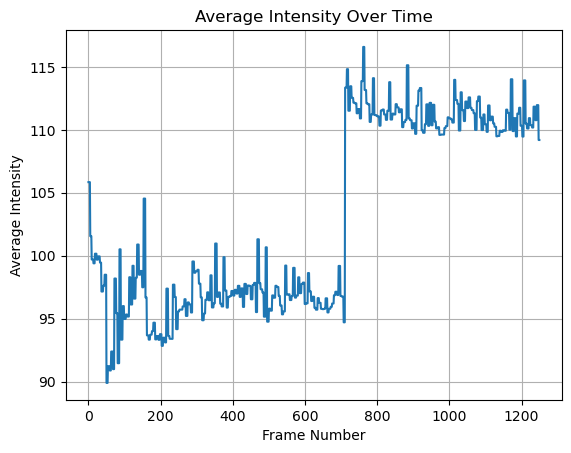

In [19]:
import cv2
import time
import ffmpeg
import matplotlib.pyplot as plt
import numpy as np
import os

st.title("Assessment AI to measure BP")

cap = cv2.VideoCapture(0)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('detected_face_video.mp4', fourcc, 30.0, (640, 480))

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    
    if ret:

        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
        
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 255, 255), 2)
        
        out.write(frame)
        
        cv2.imshow('Detecting Face', frame)

        if int(time.time() - start_time) >= 10:
            break
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()



input_video = 'detected_face_video.mp4'
output_pattern = 'frames_from_detected_face_video/detected_face_video_frame_%04d.png'

duration_seconds = 1250 / 135

(
    ffmpeg
    .input(input_video)
    .filter('fps', fps = 135)
    .output(output_pattern, start_number=0, t=duration_seconds)
    .run()
)


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

frames_directory = 'frames_from_detected_face_video/'

bounding_boxes = []

for frame_number in range(1250):
    frame_path = os.path.join(frames_directory, f'detected_face_video_frame_{frame_number:04d}.png')
    frame = cv2.imread(frame_path)

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        bounding_boxes.append((frame_number, x, y, x + w, y + h))

bounding_boxes_array = np.array(bounding_boxes)

frames_directory = 'frames_from_detected_face_video/'

average_intensities = []

for frame_number, (bbox_frame, x1, y1, x2, y2) in enumerate(bounding_boxes_array):
    frame_path = os.path.join(frames_directory, f'detected_face_video_frame_{frame_number:04d}.png')
    frame = cv2.imread(frame_path)
    
    roi = frame[int(y1):int(y2), int(x1):int(x2)]
    
    average_intensity = np.mean(roi)
    
    average_intensities.append(average_intensity)

average_intensities_array = np.array(average_intensities)

plt.plot(average_intensities_array)
plt.title('Average Intensity Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Average Intensity')
plt.grid(True)
plt.show()

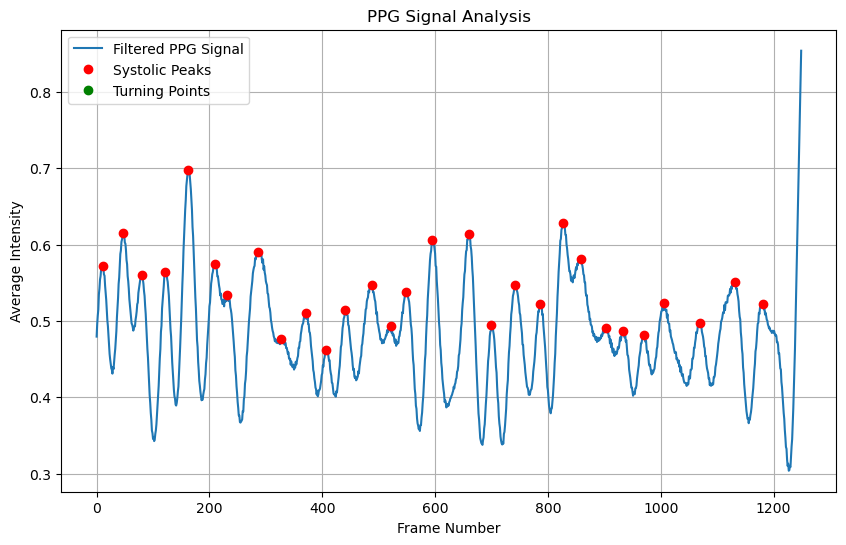

In [20]:
from scipy.signal import cheby2, filtfilt, argrelextrema

def apply_chebyshev_filter(signal, fs, cutoff_freq):
    nyquist = 0.5 * fs
    ripple_db = 20 
    b, a = cheby2(4, ripple_db, cutoff_freq / nyquist, btype='low')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def locate_systolic_peaks(signal):
    systolic_peaks_indices = argrelextrema(signal, np.greater, order=5)
    return systolic_peaks_indices

def locate_turning_points(signal, systolic_peaks_indices):
    turning_points_indices = []
    for i in range(len(systolic_peaks_indices) - 1):
        start_idx = systolic_peaks_indices[i]
        end_idx = systolic_peaks_indices[i + 1]
        min_idx = start_idx + np.argmin(signal[start_idx:end_idx])
        turning_points_indices.append(min_idx)
    return turning_points_indices

average_intensities = np.random.rand(1250)

fs = 125

filtered_ppg = apply_chebyshev_filter(average_intensities, fs, cutoff_freq=5)

systolic_peaks_indices = locate_systolic_peaks(filtered_ppg)

turning_points_indices = locate_turning_points(filtered_ppg, systolic_peaks_indices)

frame_numbers = np.arange(len(average_intensities))

plt.figure(figsize=(10, 6))
plt.plot(frame_numbers, filtered_ppg, label='Filtered PPG Signal')
plt.plot(frame_numbers[systolic_peaks_indices], filtered_ppg[systolic_peaks_indices], 'ro', markersize=6, label='Systolic Peaks')
plt.plot(frame_numbers[turning_points_indices], filtered_ppg[turning_points_indices], 'go', markersize=6, label='Turning Points')
plt.xlabel('Frame Number')
plt.ylabel('Average Intensity')
plt.title('PPG Signal Analysis')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(filtered_ppg)

[0.47944617 0.49576502 0.50684418 ... 0.78719216 0.81880824 0.85407224]


In [22]:
import pickle

with open('ppg_dataset.pkl', 'rb') as file:
    ppg_df = pickle.load(file)

print("DataFrame loaded successfully:")
ppg_df

DataFrame loaded successfully:


,PPG_F,SegDBP,SegSBP
0,"[[0.254810531724741, 0.24165416834930203, 0.22...",77.20986846942974,113.29329163322468
1,"[[0.807689007396477, 0.8328506499203419, 0.854...",58.15869802743327,100.96160427744736
2,"[[0.2614513521519598, 0.3026140511232016, 0.34...",66.2164174264126,126.5094270201927
3,"[[0.6065699555056041, 0.6350043431966792, 0.66...",53.73828352048767,101.41664183758033
4,"[[0.0598360965871831, 0.05413386510253182, 0.0...",46.05119922293933,101.80079689325987
...,...,...,...
121775,"[[0.37887745081798196, 0.44318602004405816, 0....",72.86836562474943,136.04497600249877
121776,"[[0.10822128435717421, 0.15893223734322173, 0....",73.07313606270851,149.7585146826731
121777,"[[0.8668671415536972, 0.8688951521103184, 0.86...",57.2300953852702,115.8291616759973
121778,"[[0.6931283240678398, 0.6617349342857878, 0.63...",57.9922151187843,122.00790222157902


In [23]:
from sklearn.model_selection import train_test_split

X = ppg_df['PPG_F'].values.reshape(ppg_df.values.shape[0], 1)
y = ppg_df.drop(columns=['PPG_F']).values

X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)



print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (97424, 1, 1)
y_train shape: (97424, 2)
X_test shape: (24356, 1, 1)
y_test shape: (24356, 2)


In [24]:
temp = []
for i in range(X_train.shape[0]):
    if type(X_train[i][0][0] == float):
        temp.append(np.array([X_train[i][0][0]]))
    else:
        temp.append(X_train[i][0][0][0])
X_train = temp

temp = []
for i in range(X_test.shape[0]):
    if type(X_test[i][0][0] == float):
        temp.append(np.array([X_test[i][0][0]]))
    else:
        temp.append(X_test[i][0][0][0])
X_test = temp

rows_to_delete = []
for i in range(len(X_train)):
    if X_train[i][0].shape != (1, 1250):
        rows_to_delete.append(i)
        
X_train = [X_train[i] for i in range(len(X_train)) if i not in rows_to_delete]
y_train = [y_train[i] for i in range(len(y_train)) if i not in rows_to_delete]
X_train = np.array(X_train)
y_train = np.array(y_train)

rows_to_delete = []
for i in range(len(X_test)):
    if X_test[i][0].shape != (1, 1250):
        rows_to_delete.append(i)
X_test = [X_test[i] for i in range(len(X_test)) if i not in rows_to_delete]
y_test = [y_test[i] for i in range(len(y_test)) if i not in rows_to_delete]
X_test = np.array(X_test)
y_test = np.array(y_test)

X_train = np.concatenate(X_train)
X_train = np.concatenate(X_train)
X_test = np.concatenate(X_test)
X_test = np.concatenate(X_test)


trained_model = tf.keras.models.load_model('trained_model_v1.keras')
filtered_ppg = filtered_ppg.reshape((1, 1250, 1))
predictions = trained_model.predict(filtered_ppg)

print('Estimated BP: ', predictions[0][1],'/',predictions[0][0])

1/1 [==============================] - 1s 1s/step
Estimated BP:  117.59244 / 61.529583
